# TRANSMISSÃO E RECEPÇÃO DE DADOS PARA COMUNICAÇÃO DE PCDs VIA SATÉLITE


In [2]:
import numpy as np
import matplotlib.pyplot as plt

# Plot da versão do numpy
print("Versão do numpy: ", np.__version__)

Versão do numpy:  1.26.4


In [3]:
# Formação do campo de dados de sensores

# Número de sensores
sensor_count = 4

# Comprimento dos dados
data_length = 8 


# Função para gerar randomicamente os dados de um sensor em binário
def generate_sensor_data():
    return np.random.randint(0, 2, data_length)

# Função para concatenar os dados de sensor_count sensores 
def generate_sensor_block():
    sensor_data = generate_sensor_data()
    for i in range(sensor_count - 1):
        sensor_data = np.concatenate((sensor_data, generate_sensor_data()))
    return sensor_data

# Função para imprimir os dados armazenados em binário
def print_sensor_data(sensor_data):
    print("Bloco de dados: ")
    print(sensor_data)

print_sensor_data(generate_sensor_block())



Bloco de dados: 
[0 1 0 1 1 0 1 1 0 0 1 1 0 0 0 1 1 0 1 1 1 0 0 0 0 0 0 0 0 0 1 0]


In [4]:
# Função para gerar o campo de dados de sensores

# Número de blocos
block_count = 5

# Função para gerar e concatenar blocos de dados

def generate_sensor_data_block():
    sensor_data = generate_sensor_block()
    for i in range(block_count - 1):
        sensor_data = np.concatenate((sensor_data, generate_sensor_block()))
    return sensor_data

# Função para imprimir os dados armazenados em binário
def print_sensor_data_block(sensor_data):
    print("Datagrama: ")
    print(sensor_data)

print_sensor_data_block(generate_sensor_data_block())

Datagrama: 
[1 1 1 0 0 1 1 0 0 1 1 0 1 1 0 1 1 1 0 1 1 0 0 1 1 0 1 0 1 0 1 1 1 0 1 0 1
 0 1 0 1 0 1 1 0 0 1 1 1 0 0 1 1 0 0 1 1 0 0 0 1 0 1 0 0 1 0 0 1 1 1 0 1 1
 1 1 1 1 1 1 0 1 0 1 0 1 1 0 0 1 0 1 1 0 1 0 1 1 0 0 1 1 0 0 1 0 0 1 0 1 0
 1 1 0 1 0 1 1 1 0 1 0 1 1 0 1 0 1 0 0 0 0 1 0 1 0 0 0 1 1 1 1 0 1 1 0 0 1
 1 1 1 0 1 1 1 1 1 0 0 0]


In [5]:
# Função para gerar o campo de identificação da PCD (ponto de coleta de dados)

# Número de bits de identificação
pcd_id_length = 16

# Função para gerar gerar um PCD_ID e checksum da PCD e concatenar ao campo de identificação
def generate_pcd_id_with_checksum():
    pcd_id = np.random.randint(0, 2, pcd_id_length)
    checksum = np.sum(pcd_id) % 2
    pcd_id = np.concatenate((pcd_id, np.array([checksum])))
    return pcd_id




In [6]:
# Número de bits de identificação
pcd_id_length = 16

pcd_id = np.random.randint(0, 2, pcd_id_length)

# Função para gerar o campo de identificação da PCD com Hamming
def generate_pcd_id_with_hamming(pcd_id):
    # Calcula o número de bits de paridade necessários
    # 2^p >= pcd_id_length + p + 1
    p = 0
    while 2**p < pcd_id_length + p + 1:
        p += 1

    # Cria um array com espaços para bits de paridade
    hamming_code_length = pcd_id_length + p
    hamming_code = np.zeros(hamming_code_length, dtype=int)

    # Preenche os bits de dados (não nas posições de paridade)
    data_index = 0
    for i in range(1, hamming_code_length + 1):
        if (i & (i - 1)) != 0:  # Não é potência de 2
            hamming_code[i - 1] = pcd_id[data_index]
            data_index += 1

    # Calcula os bits de paridade
    for i in range(p):
        parity_position = 2**i
        parity_value = 0
        for j in range(1, hamming_code_length + 1):
            if j & parity_position:
                parity_value ^= hamming_code[j - 1]
        hamming_code[parity_position - 1] = parity_value

    return hamming_code

# Exemplo de uso
print("PCD ID:", pcd_id)
pcd_id_with_hamming = generate_pcd_id_with_hamming(pcd_id)
print("PCD ID com Hamming:", pcd_id_with_hamming)

PCD ID: [1 1 0 0 1 1 0 0 1 0 0 0 0 1 0 1]
PCD ID com Hamming: [0 1 1 1 1 0 0 1 1 1 0 0 1 0 0 0 0 0 1 0 1]


In [7]:
# Função para criar o campo de tamanho da mensagem com base no número de blocos

n = block_count - 1

# converte n para binário de 3bits

def convert_to_binary(n):
    return np.array([int(x) for x in bin(n)[2:].zfill(3)])

print("Tamanho da mensagem: ", convert_to_binary(n))

# Função para concatenar um bit de paridade ao campo de tamanho da mensagem

def message_length_block(n):
    parity = np.sum(n) % 2
    return np.concatenate((n, np.array([parity])))

print("Tamanho da mensagem com bit de paridade: ", message_length_block(convert_to_binary(n))) 



Tamanho da mensagem:  [1 0 0]
Tamanho da mensagem com bit de paridade:  [1 0 0 1]


In [8]:
# Função para criar o preâmbulo da mensagem 

# Número de bits de sincronização do preâmbulo
sincronization_bit = 15 # bits "1" 
sincronization_character = 8 # bits "00010111"
end_bit = 1

# Função para gerar o preâmbulo da mensagem
def generate_preamble():
    preamble = np.ones(sincronization_bit)
    
    # concatena "00010111" ao final preâmbulo
    preamble = np.concatenate((preamble, np.array([0, 0, 0, 1, 0, 1, 1, 1])))

    # concatena "1" ao final do preâmbulo
    preamble = np.concatenate((preamble, np.array([end_bit])))
    return preamble

print("Preâmbulo: ", generate_preamble())

Preâmbulo:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 1. 0. 1. 1. 1. 1.]


In [9]:
# Função para concatenar todos os campos da mensagem formando o datagrama completo

def generate_datagram():
    datagram = generate_preamble()
    datagram = np.concatenate((datagram, message_length_block(convert_to_binary(n))))
    datagram = np.concatenate((datagram, generate_pcd_id_with_hamming(pcd_id)))
    datagram = np.concatenate((datagram, generate_sensor_data_block()))
    return datagram

print("Datagrama completo: ", generate_datagram())

Datagrama completo:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 1. 0. 1. 1. 1. 1.
 1. 0. 0. 1. 0. 1. 1. 1. 1. 0. 0. 1. 1. 1. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0.
 1. 1. 1. 1. 0. 1. 0. 0. 1. 1. 1. 1. 1. 1. 0. 0. 1. 0. 0. 0. 1. 1. 0. 0.
 1. 0. 1. 0. 1. 0. 0. 1. 1. 0. 1. 0. 1. 0. 0. 1. 0. 1. 0. 0. 1. 1. 0. 1.
 0. 1. 0. 0. 1. 1. 1. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 1. 1.
 1. 0. 0. 1. 1. 1. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 1. 1. 1. 1. 1. 1. 0.
 1. 1. 1. 1. 0. 1. 0. 0. 1. 1. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 1. 1. 0.
 1. 1. 0. 1. 1. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 1. 0. 1.
 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 1. 1. 0. 0. 1. 0.]


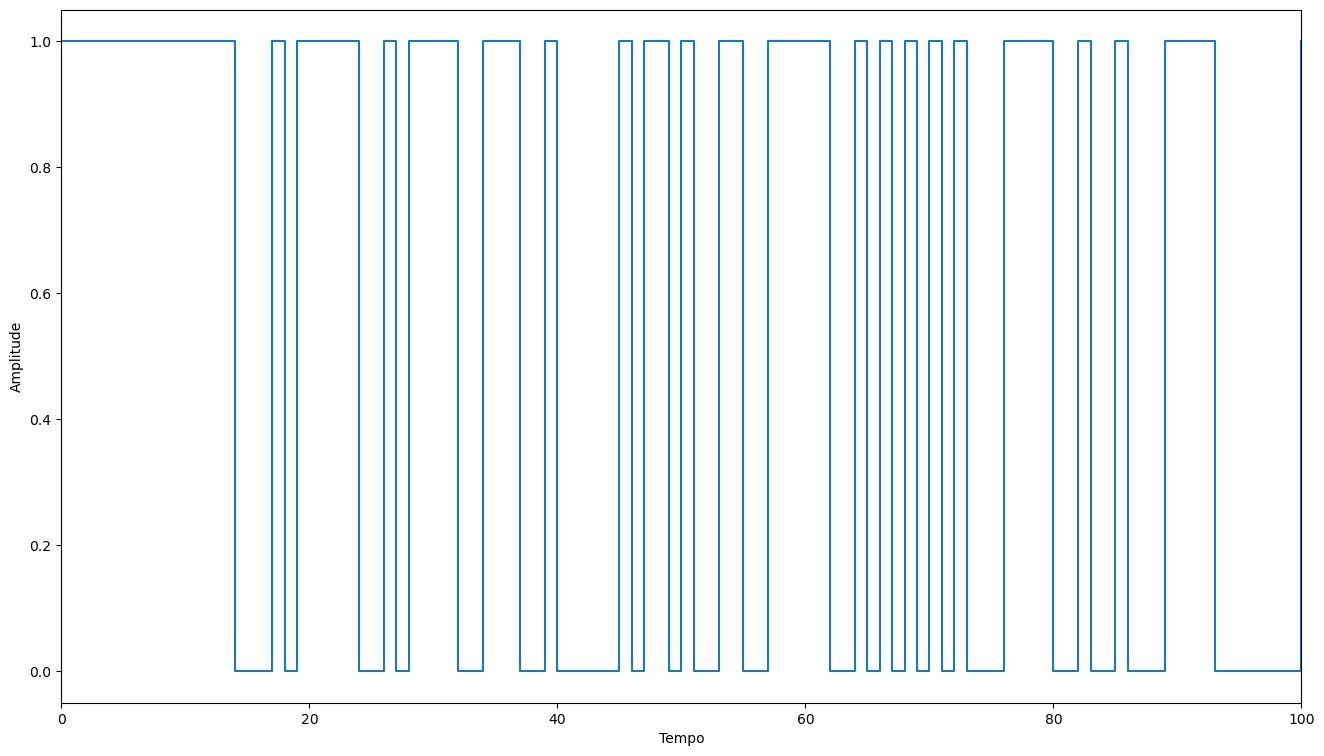

In [10]:
# Função para imprimir o datagrama em gráfico com NRZ (Non-Return-to-Zero), sendo -5 o bit 0 e 5 o bit 1

def plot_datagram(datagram):
    plt.figure(figsize=(16, 9))
    plt.xlim(0, 100)
    plt.step(range(len(datagram)), datagram)
    plt.ylabel("Amplitude")
    plt.xlabel("Tempo")
    
plot_datagram(generate_datagram())



Mensagem codificada:  [0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 1 0 1 0 1 0 0
 1 1 0 0 1 0 1 0 1 0 1 0 1 1 0 1 0 0 1 1 0 0 1 0 1 0 1 0 1 1 0 1 0 0 1 0 1
 0 1 1 0 1 0 0 1 1 0 1 0 1 0 1 0 1 0 0 1 1 0 0 1 0 1 1 0 1 0 0 1 1 0 1 0 1
 0 1 0 0 1 1 0 1 0 1 0 0 1 0 1 1 0 0 1 1 0 0 1 1 0 0 1 1 0 0 1 0 1 1 0 1 0
 1 0 0 1 1 0 0 1 1 0 0 1 0 1 1 0 0 1 0 1 1 0 1 0 1 0 1 0 0 1 0 1 1 0 0 1 0
 1 1 0 0 1 1 0 1 0 0 1 1 0 1 0 1 0 1 0 0 1 0 1 0 1 0 1 1 0 0 1 0 1 0 1 0 1
 1 0 1 0 0 1 0 1 0 1 0 1 1 0 0 1 1 0 1 0 1 0 0 1 0 1 0 1 1 0 0 1 1 0 0 1 0
 1 0 1 1 0 0 1 1 0 1 0 1 0 0 1 0 1 0 1 1 0 1 0 0 1 1 0 0 1 0 1 0 1 1 0 1 0
 1 0 1 0 1 0 0 1 0 1 1 0 0 1 1 0 0 1 1 0 1 0 1 0 0 1 1 0 1 0 1 0 1 0 1 0 0
 1 0 1 0 1 1 0 0 1 1 0 1 0 0 1 1 0 0 1 0 1 0 1 1 0 0 1 0 1 0 1 1 0 1 0 1 0
 1 0 0 1 0 1 1 0 0 1 0 1 0 1 1 0 0 1 1 0 1 0 0 1 1 0 1 0 1 0 1 0 0 1 0 1 1
 0 0 1 1 0 1 0 0 1 1 0]


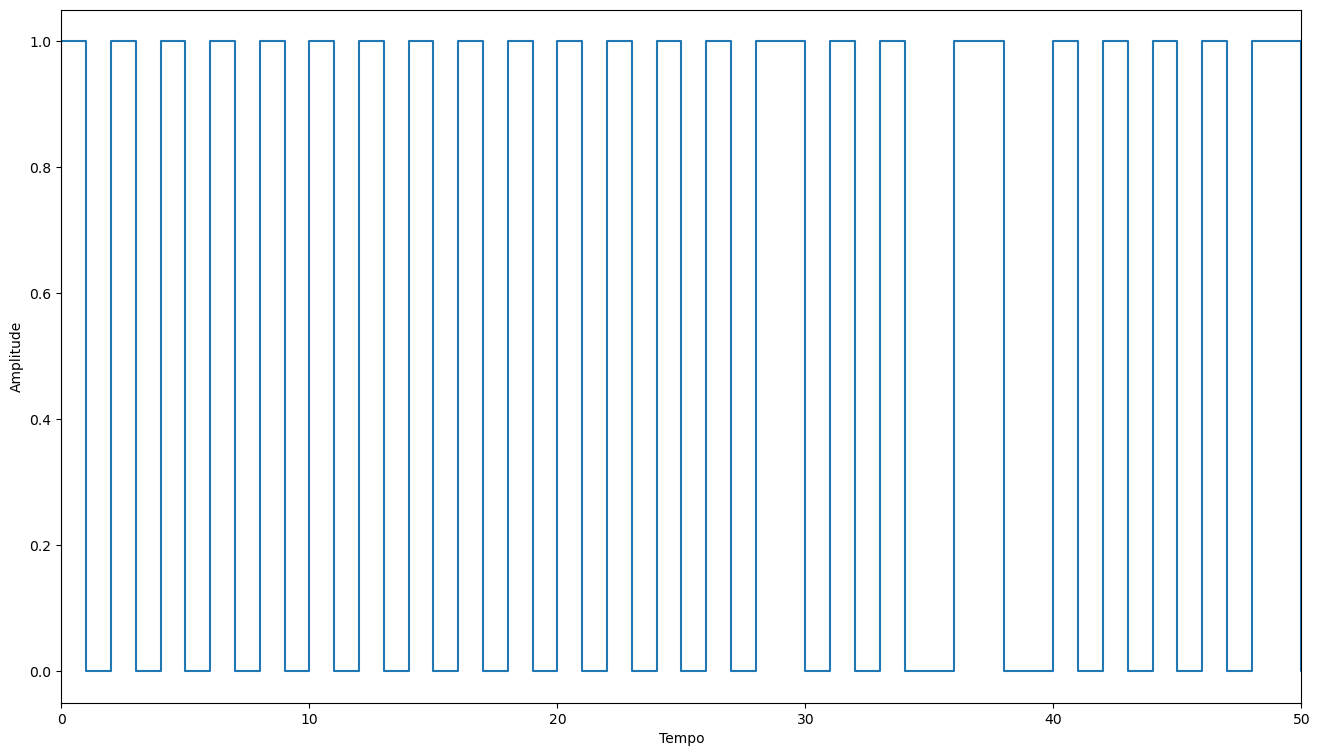

In [11]:
# Codifica a mensagem em Manchester

def encode_manchester(data):
    encoded_data = np.zeros(len(data) * 2, dtype=int)
    for i in range(len(data)):
        if data[i] == 0:
            encoded_data[2 * i] = 1
            encoded_data[2 * i + 1] = 0
        else:
            encoded_data[2 * i] = 0
            encoded_data[2 * i + 1] = 1
    return encoded_data

# imprime a mensagem codificada em um gráfico
data = generate_datagram()
encoded_data = encode_manchester(data)

print("Mensagem codificada: ", encoded_data)

plt.figure(figsize=(16, 9))
plt.step(range(len(encoded_data)), encoded_data)
plt.xlim(0, 50)
plt.xlabel("Tempo")
plt.ylabel("Amplitude")
plt.show()


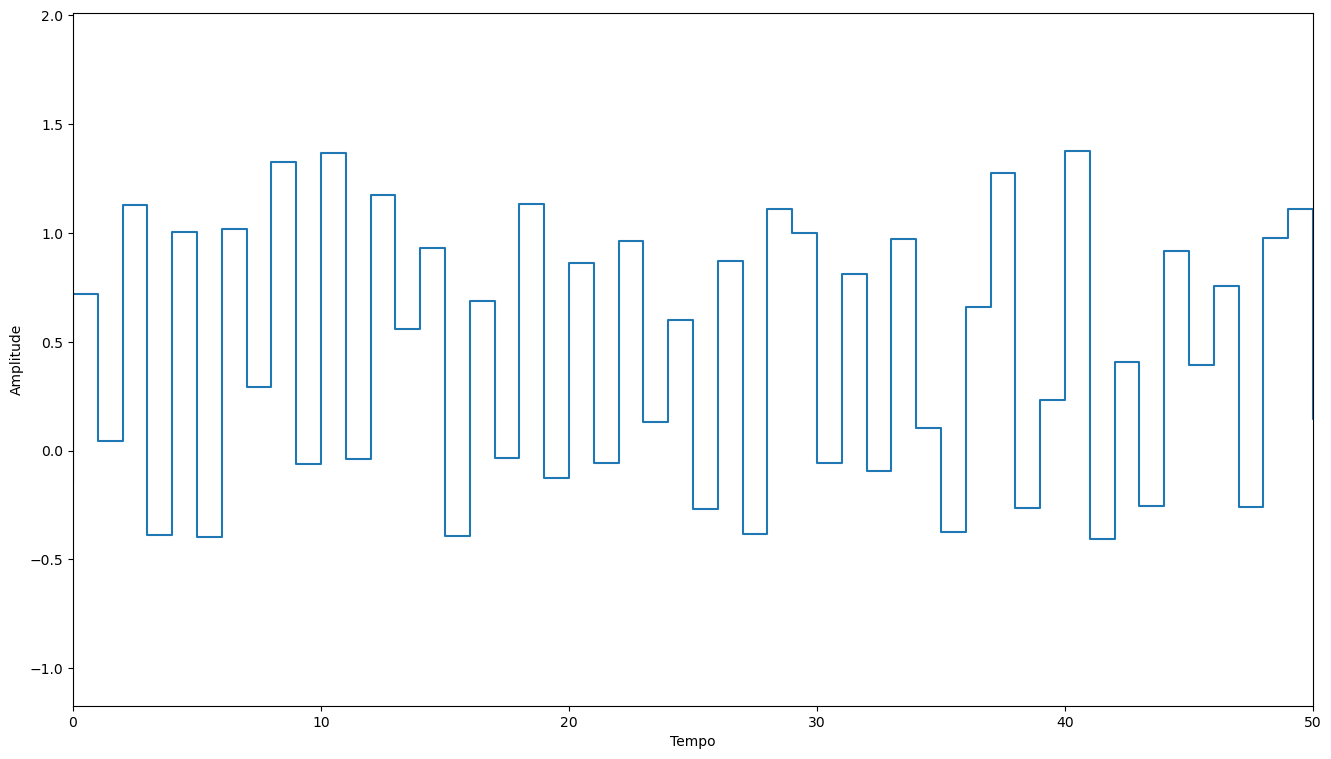

In [12]:
# adiciona ruído gaussiano à mensagem codificada

def add_noise(data, noise_amplitude):
    noise = np.random.normal(0, noise_amplitude, len(data))
    return data + noise

# imprime a mensagem codificada com ruído em um gráfico
noise_amplitude = 0.3
noisy_data = add_noise(encoded_data, noise_amplitude)

plt.figure(figsize=(16, 9))
plt.step(range(len(noisy_data)), noisy_data)
plt.xlim(0, 50)
plt.xlabel("Tempo")
plt.ylabel("Amplitude")
plt.show()

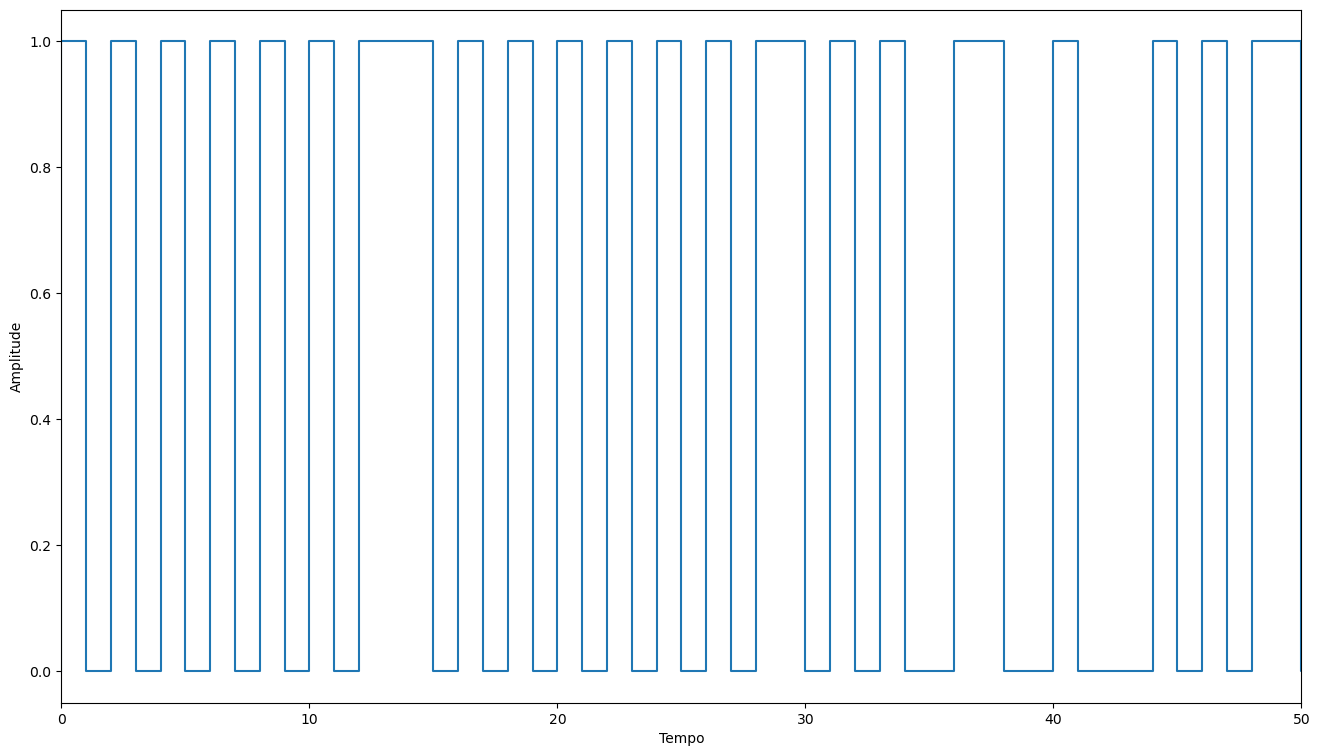

In [13]:
# Quantiza a mensagem codificada com ruído

def quantize(data, threshold):
    return np.array([0 if x < threshold else 1 for x in data])

# imprime a mensagem codificada com ruído e quantizada em um gráfico
threshold = 0.5
quantized_data = quantize(noisy_data, threshold)

plt.figure(figsize=(16, 9))
plt.step(range(len(quantized_data)), quantized_data)
plt.xlim(0, 50)
plt.xlabel("Tempo")
plt.ylabel("Amplitude")
plt.show()


In [14]:
print("mensagem quantizada: ", quantized_data)
print("mensagem original: ", encoded_data)

mensagem quantizada:  [0 1 0 1 0 1 0 1 0 1 0 1 0 1 1 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 1 0 1 0 1 0 0
 1 1 0 0 1 0 0 0 1 0 1 0 1 1 0 1 0 1 1 1 0 0 1 0 1 0 1 0 1 1 0 1 0 0 1 0 1
 0 1 1 0 1 0 0 1 1 0 1 0 1 0 1 0 1 1 0 1 1 0 0 1 0 1 1 0 1 0 0 1 1 0 1 0 1
 0 1 0 0 1 1 0 0 0 1 0 0 1 0 1 1 0 0 0 1 0 0 1 1 0 0 1 1 0 0 1 0 1 1 0 1 0
 1 0 0 1 1 0 0 1 1 0 0 1 0 1 1 0 0 0 0 1 0 0 1 0 1 0 1 0 0 1 0 1 1 0 0 1 0
 1 1 0 0 1 0 0 1 0 0 1 1 0 1 0 1 0 1 0 0 1 0 1 0 1 0 1 1 0 0 1 0 1 0 1 0 1
 1 0 1 0 0 1 0 1 0 1 0 1 1 0 0 1 0 0 1 0 0 0 0 1 0 1 0 1 1 0 0 1 1 0 0 1 0
 1 0 1 1 0 0 1 1 0 1 0 1 0 0 1 0 1 0 1 1 0 1 0 0 1 1 0 0 1 0 1 0 1 1 0 1 0
 1 0 1 0 1 0 0 1 0 1 1 0 0 1 1 0 0 1 1 0 1 0 1 0 0 1 1 0 1 0 1 0 1 0 1 0 1
 1 0 1 0 1 1 0 0 1 1 0 1 0 0 1 1 0 0 1 0 1 0 1 1 0 0 1 0 1 0 1 1 0 1 0 1 0
 1 0 0 1 0 1 1 0 0 1 0 1 0 1 1 0 0 1 1 0 1 0 0 1 1 0 1 0 1 0 1 0 0 1 0 1 1
 0 0 1 1 0 1 0 0 1 1 0]
mensagem original:  [0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 1 0 1 0 1 0 0
 1 1 0 0 1 0 1 0 1 0 1 0 1 1 0 1 0

In [15]:
# Decodifica a mensagem de Manchester

# Decodifica a mensagem de Manchester
def decode_manchester(encoded_data, tolerance=0.1):
    if len(encoded_data) % 2 != 0:
        raise ValueError("Os dados codificados devem ter um número par de elementos.")
    
    decoded_data = np.zeros(len(encoded_data) // 2, dtype=int)
    
    for i in range(0, len(encoded_data), 2):
        if abs(encoded_data[i] - 1) < tolerance and abs(encoded_data[i+1]) < tolerance:
            decoded_data[i // 2] = 0  # Padrão '10'
        elif abs(encoded_data[i]) < tolerance and abs(encoded_data[i+1] - 1) < tolerance:
            decoded_data[i // 2] = 1  # Padrão '01'
    
    return decoded_data

# imprime a mensagem decodificada no console
decoded_data = decode_manchester(quantized_data)

print ("Mensagem codificada: ", data.astype(int))
print("Mensagem decodificada: ", decoded_data)

Mensagem codificada:  [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 1 0 1 1 1 1 1 0 0 1 0 1 1 1 1 0 0 1 1
 1 0 0 1 0 0 0 0 0 1 0 1 1 0 0 1 0 0 0 0 1 0 0 0 1 1 0 1 0 1 0 1 0 1 1 0 0
 0 1 0 1 0 1 1 0 1 1 0 0 0 0 1 1 0 1 1 0 1 0 0 1 0 0 0 0 1 1 1 1 0 1 1 1 1
 0 0 1 1 1 1 0 1 0 0 0 1 1 1 0 1 0 1 1 1 0 1 0 0 0 1 1 1 0 0 1 0 1 1 1 0 0
 0 0 0 1 1 0 1 0 1 0 0 0 1 0 0 0 0 0 1 1 1 0 1 0 0 1 0 1 1 1 0 1 1 1 0 0 0
 0 1 1 0 1 1 1 0 1 0 0 1 0 0 0 0 1 1 0 1 0 0 1 0]
Mensagem decodificada:  [1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 0 0 0 1 0 1 0 1 1 1 0 0 0 0 1 1 1 1 0 0 1 1
 1 0 0 1 0 0 0 0 0 1 0 1 1 0 0 1 0 0 0 0 1 0 0 0 1 1 0 0 0 1 0 1 0 1 1 0 0
 0 1 0 1 0 1 1 0 0 1 0 0 0 0 1 1 0 1 1 0 1 0 0 1 0 0 0 0 1 1 1 1 0 1 1 1 1
 0 0 1 1 1 1 0 1 0 0 0 1 1 1 0 1 0 1 1 1 0 1 0 0 0 1 1 1 0 0 1 0 1 1 1 0 0
 0 0 0 1 1 0 1 0 1 0 0 0 1 0 0 0 0 0 0 1 1 0 1 0 0 1 0 1 1 1 0 1 1 1 0 0 0
 0 1 1 0 1 1 1 0 1 0 0 1 0 0 0 0 1 1 0 1 0 0 1 0]


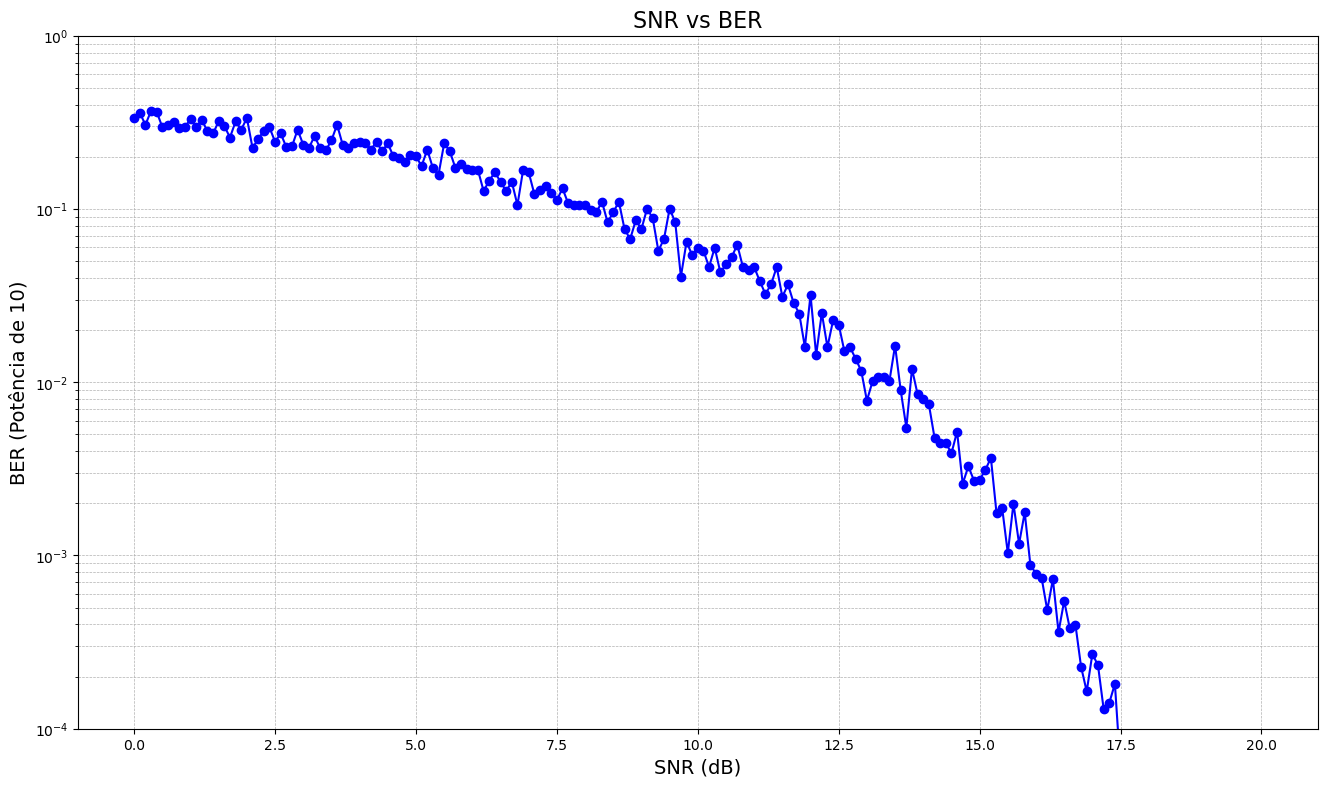

SNR (dB)	BER
0.0		0.33493
0.1		0.35885
0.2		0.30622
0.3		0.36842
0.4		0.36364
0.5		0.29665
0.6		0.30622
0.7		0.31579
0.8		0.29187
0.9		0.29665
1.0		0.33014
1.1		0.29665
1.2		0.32536
1.3		0.28230
1.4		0.27273
1.5		0.32057
1.6		0.30144
1.7		0.25837
1.8		0.32057
1.9		0.28708
2.0		0.33493
2.1		0.22488
2.2		0.25359
2.3		0.28230
2.4		0.29665
2.5		0.24402
2.6		0.27273
2.7		0.22727
2.8		0.22967
2.9		0.28708
3.0		0.23445
3.1		0.22488
3.2		0.26316
3.3		0.22488
3.4		0.21770
3.5		0.24880
3.6		0.30622
3.7		0.23445
3.8		0.22488
3.9		0.23923
4.0		0.24402
4.1		0.23923
4.2		0.22010
4.3		0.24402
4.4		0.21531
4.5		0.23923
4.6		0.20096
4.7		0.19617
4.8		0.18660
4.9		0.20574
5.0		0.20096
5.1		0.17703
5.2		0.22010
5.3		0.17225
5.4		0.15789
5.5		0.23923
5.6		0.21531
5.7		0.17225
5.8		0.18182
5.9		0.16986
6.0		0.16746
6.1		0.16746
6.2		0.12679
6.3		0.14593
6.4		0.16268
6.5		0.14354
6.6		0.12679
6.7		0.14354
6.8		0.10526
6.9		0.16746
7.0		0.16268
7.1		0.12201
7.2		0.12919
7.3		0.13636
7.4		0.12440
7.5		0.11244

In [25]:
import numpy as np
import matplotlib.pyplot as plt

# SNR com precisão de 0.1 dB
snr_values = np.arange(0, 20.1, 0.1)
ber_values = []

def get_max_errors(snr):
    """ Retorna o número de erros a serem contados com base na SNR.
        Começa com 50 erros e reduz até 1 conforme a SNR aumenta. """
    return max(1, int(50 * (1 - snr / 20)))  # Decai linearmente de 50 para 1

def plot_snr_vs_ber():
    for snr in snr_values:
        noise_amplitude = 10**(-snr / 20.0)
        error_count = 0
        total_bits = 0
        max_errors = get_max_errors(snr)  # Define quantos erros contar antes de avançar
        
        while error_count < max_errors:
            noisy_data = add_noise(encoded_data, noise_amplitude)
            quantized_data = quantize(noisy_data, threshold)
            decoded_data = decode_manchester(quantized_data)

            errors = np.sum(decoded_data != data)
            error_count += errors
            total_bits += len(data)
        
        ber = error_count / total_bits
        ber_values.append(ber)

    plt.figure(figsize=(16, 9))
    plt.plot(snr_values, ber_values, color='b', linestyle='-', marker='o')
    plt.xlabel("SNR (dB)", fontsize=14)
    plt.ylabel("BER (Potência de 10)", fontsize=14)
    plt.title("SNR vs BER", fontsize=16)
    
    plt.yscale('log')
    plt.ylim([10**-4, 1])    
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.show()

plot_snr_vs_ber()

print("SNR (dB)\tBER")
for i in range(len(snr_values)):
    print("{:.1f}\t\t{:.5f}".format(snr_values[i], ber_values[i]))
